# JetClass PMNN Plotting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def sort_legend_items(items):
    return sorted(items, key=lambda x: (len(x), x))


In [ ]:
import pandas as pd
import warnings
import numpy as np

# Suppress all warnings
warnings.filterwarnings('ignore')


# Load the DataFrame
results_df = pd.read_csv('JetClass_PMNN_h4q_processed_performance.csv').sort_values('overall_accuracy', ascending=False)

# Split the 'base_name' column to extract the relevant components
split_columns = results_df['base_name'].str.split('_', expand=True)

# Assigning the last four elements to new columns
results_df[['particle_geom', 'particle_dim']] = split_columns.iloc[:, 1:3]

# Convert 'particle_dim' and 'jet_dim' to integers
results_df['particle_dim'] = results_df['particle_dim'].astype(int)
# results_df['jet_dim'] = results_df['jet_dim'].astype(int)

results_df['particle_dim'] = results_df.apply(
    lambda row: row['particle_dim'] * 2 if len(row['particle_geom']) > 1 else row['particle_dim'],
    axis=1
)

# Remove the original 'base_name' column if it's no longer needed
results_df.drop(columns=['base_name'], inplace=True)

# Create a list of tuples for the MultiIndex
index_tuples = list(results_df[['particle_geom', 'particle_dim']].itertuples(index=False, name=None))

# Create a MultiIndex
index = pd.MultiIndex.from_tuples(index_tuples, names=['particle_geom', 'particle_dim'])

# Assign the MultiIndex to the DataFrame
results_df.index = index
# Define a function to average the top 2 'overall_accuracy' for each unique (particle_geom, particle_dim) combination

# Apply the function to the DataFrame
averaged_df = average_top_2_for_each(results_df)

# Drop the now redundant columns 'particle_geom' and 'particle_dim' if needed
# 
# Assign the result back to results_df or keep it as a new DataFrame
results_df = averaged_df

index_tuples = list(results_df[['particle_geom', 'particle_dim']].itertuples(index=False, name=None))

index = pd.MultiIndex.from_tuples(index_tuples, names=['particle_geom', 'particle_dim'])

# Assign the MultiIndex to the DataFrame
results_df.index = index
results_df.drop(columns=['particle_geom', 'particle_dim'], inplace=True)

results_df#.nlargest(2, 'overall_accuracy')

JetClass_df = results_df
# Print or display the DataFrame to check the structure
# print(results_df.head())
    
signals = ['H4q']
line_h4q, caplines_h4q, bars_h4q,labels_h4q = plot_acc(JetClass_df,title = f'$H \\rightarrow 4q $',rejection=50,classes = signals, variable_to_vary='particle_dim',PMNN = True, acc_range = [70,90])

In [ ]:
line_h4q.get_label()

In [ ]:
import pandas as pd
import warnings
import numpy as np

# Suppress all warnings
warnings.filterwarnings('ignore')

# Load the DataFrame
results_df = pd.read_csv('JetClass_PMNN_tbqq_processed_performance.csv').sort_values('overall_accuracy', ascending=False)

# Split the 'base_name' column to extract the relevant components
split_columns = results_df['base_name'].str.split('_', expand=True)

# Assigning the last four elements to new columns
results_df[['particle_geom', 'particle_dim']] = split_columns.iloc[:, 1:3]

# Convert 'particle_dim' and 'jet_dim' to integers
results_df['particle_dim'] = results_df['particle_dim'].astype(int)
# results_df['jet_dim'] = results_df['jet_dim'].astype(int)

# results_df['particle_dim'] = results_df.apply(
#     lambda row: row['particle_dim'] * 2 if len(row['particle_geom']) > 1 else row['particle_dim'],
#     axis=1
# )

# # Multiply 'jet_dim' by 2 if the length of 'jet_geom' is greater than 1
# results_df['jet_dim'] = results_df.apply(
#     lambda row: row['jet_dim'] * 2 if len(row['jet_geom']) > 1 else row['jet_dim'],
#     axis=1
# )


# Remove duplicates by keeping the row with the highest overall_accuracy
# results_df = results_df.sort_values('overall_accuracy', ascending=False)
# .drop_duplicates(
#     subset=['particle_geom', 'particle_dim'], keep='first'
# )

# Remove the original 'base_name' column if it's no longer needed
results_df.drop(columns=['base_name'], inplace=True)

# Create a list of tuples for the MultiIndex
index_tuples = list(results_df[['particle_geom', 'particle_dim']].itertuples(index=False, name=None))

# Create a MultiIndex
index = pd.MultiIndex.from_tuples(index_tuples, names=['particle_geom', 'particle_dim'])

# Assign the MultiIndex to the DataFrame
results_df.index = index
# Define a function to average the top 2 'overall_accuracy' for each unique (particle_geom, particle_dim) combination

def average_top_2_for_each(df):
    # Initialize an empty list to store the averaged rows
    averaged_rows = []

    # Get the unique combinations of 'particle_geom' and 'particle_dim'
    unique_combinations = df[['particle_geom', 'particle_dim']].drop_duplicates()

    # Iterate through each combination
    for _, row in unique_combinations.iterrows():
#         print(row['particle_geom'])
#         print(row['particle_dim'])
        particle_geom = row['particle_geom']
        particle_dim = row['particle_dim']

        # Filter the DataFrame for the current combination
        filtered_df = df[(df['particle_geom'] == particle_geom) & (df['particle_dim'] == particle_dim)]

        # Sort by 'overall_accuracy' and take the top 2 rows
        top_2 = filtered_df.nlargest(2, 'overall_accuracy')
        
        # Compute the average of the top 2 rows
        averaged_row = top_2.mean()
        # Compute the average of the top 2 rows
        std_1 = top_2.iloc[0]['acc_std']
        std_2 = top_2.iloc[1]['acc_std']
        propagated_std = np.sqrt(std_1**2 + std_2**2) / 2

        # Set 'acc_std' to the propagated uncertainty
        averaged_row['acc_std'] = propagated_std
        # Add the particle_geom and particle_dim back to the averaged row
        averaged_row['particle_geom'] = particle_geom
        averaged_row['particle_dim'] = particle_dim

        # Append the averaged row to the list
        averaged_rows.append(averaged_row)

    # Create a new DataFrame from the averaged rows
    averaged_df = pd.DataFrame(averaged_rows)

    return averaged_df
# Apply the function to the DataFrame
averaged_df = average_top_2_for_each(results_df)

# Drop the now redundant columns 'particle_geom' and 'particle_dim' if needed
# 
# Assign the result back to results_df or keep it as a new DataFrame
results_df = averaged_df
results_df['particle_dim'] = results_df.apply(
    lambda row: row['particle_dim'] * 2 if len(row['particle_geom']) > 1 else row['particle_dim'],
    axis=1
)
index_tuples = list(results_df[['particle_geom', 'particle_dim']].itertuples(index=False, name=None))

index = pd.MultiIndex.from_tuples(index_tuples, names=['particle_geom', 'particle_dim'])

# Assign the MultiIndex to the DataFrame
results_df.index = index
results_df.drop(columns=['particle_geom', 'particle_dim'], inplace=True)

results_df#.nlargest(2, 'overall_accuracy')

JetClass_df = results_df
# Print or display the DataFrame to check the structure
# print(results_df.head())
    
signals = ['tbqq']
line_tbqq, caplines_tbqq, bars_tbqq,labels_tbqq = plot_acc(JetClass_df,title = 'JetClass tagging',rejection=50,classes = signals, variable_to_vary='particle_dim',PMNN = True,acc_range=[70,90])

In [ ]:
# Assuming bars_tbqq is a tuple, access the first element
first_bars = bars_tbqq[0]  # Access the first element which should be the LineCollection

# Get x and y data for the line
x_data = first_line.get_xdata()
y_data = first_line.get_ydata()

# Get the error bar segments (each segment is a line corresponding to an error bar)
error_bar_segments = first_bars.get_segments()  # Get segments from the LineCollection

# The error bar segments contain pairs of points [(x0, y0), (x1, y1)]
# We'll extract the y-values from these segments to get the lower and upper bounds
lower_bounds = [seg[0][1] for seg in error_bar_segments]  # The first point in each segment is the lower bound
upper_bounds = [seg[1][1] for seg in error_bar_segments]  # The second point in each segment is the upper bound

# Print the results
print("X Data:", x_data)
print("Y Data:", y_data)
print("Lower Error Bars:", lower_bounds)
print("Upper Error Bars:", upper_bounds)

In [ ]:
import matplotlib.pyplot as plt
import itertools
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator

# Define a list of colors to use
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a color cycle from the 'tab10' colormap

# Create figure with GridSpec to control spacing
fig = plt.figure(figsize=(16, 6), dpi=300)

# Create GridSpec layout with more control over subplot spacing
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)  # wspace controls the distance between subplots

# Create subplots with more distance between them
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)

markers = ['o', 's', 'p', 'h', '^', 'v', '*', 'x']  # Define markers

# Step 2: Plot the error bars for lines_h4q on ax1 with solid lines and markers
for i, line in enumerate(lines_h4q):  # Now expecting Line2D objects
    x_data = line.get_xdata()  # Get x data
    y_data = line.get_ydata()  # Get y data
    first_bars = bars_h4q[i][0]  # Access the first element which should be the LineCollection

    # Get the error bar segments (each segment is a line corresponding to an error bar)
    error_bar_segments = first_bars.get_segments()  # Get segments from the LineCollection

    lower_bounds = [seg[0][1] for seg in error_bar_segments]  # The first point in each segment is the lower bound
    upper_bounds = [seg[1][1] for seg in error_bar_segments]  # The second point in each segment is the upper bound
    yerr_data = np.array(upper_bounds) -np.array(lower_bounds)
    
    color = next(colors)  # Get the next color from the cycle
    ax1.errorbar(x_data, y_data, yerr=yerr_data, fmt='-',  # Solid line with marker
                 label=line.get_label(), linewidth=4,color=color)

# Step 3: Reset the color cycle for the second set of lines
colors = itertools.cycle(plt.cm.tab10.colors)  # Reset the color cycle

# Step 4: Plot the error bars for lines_tbqq on ax2 with solid lines and markers
for i, line in enumerate(lines_tbqq):  # Now expecting Line2D objects
    x_data = line.get_xdata()  # Get x data
    y_data = line.get_ydata()  # Get y data
    
    # If error bars are stored in a separate list (e.g., yerr_tbqq), you need to pass them here
    first_bars = bars_tbqq[i][0]  # Access the first element which should be the LineCollection

    # Get the error bar segments (each segment is a line corresponding to an error bar)
    error_bar_segments = first_bars.get_segments()  # Get segments from the LineCollection

    lower_bounds = [seg[0][1] for seg in error_bar_segments]  # The first point in each segment is the lower bound
    upper_bounds = [seg[1][1] for seg in error_bar_segments]  # The second point in each segment is the upper bound
    yerr_data = np.array(upper_bounds) -np.array(lower_bounds)

    color = next(colors)  # Get the next color from the cycle
    ax2.errorbar(x_data, y_data, yerr=yerr_data, fmt='-',  # Solid line with marker
                 label=labels_tbqq[i], linewidth=4, color=color)
    

# Step 5: Set the shared y-axis range for both subplots
ax1.set_ylim(70, 90)
ax2.set_ylim(70, 90)
ax1.set_xlim(4, 64)
ax2.set_xlim(4, 64)
ax1.set_xscale('log', base=2)
ax2.set_xscale('log', base=2)
ax1.set_title(f'$H \\rightarrow 4q$', fontsize=30, pad=30)
ax1.text(0.5, 1.07, "Most Hierarchical", fontsize=20, ha='center', va='top', transform=ax1.transAxes)

ax2.set_title(f'$t \\rightarrow bqq\'$', fontsize=30, pad=30)
ax2.text(0.5, 1.07, "Least Hierarchical", fontsize=20, ha='center', va='top', transform=ax2.transAxes)

ax1.tick_params(axis='x', which='major', labelsize=20, labelcolor='black', direction='out', length=6)
ax1.tick_params(axis='y', which='major', labelsize=20, labelcolor='black', direction='in', length=4)
ax2.tick_params(axis='x', which='major', labelsize=20, labelcolor='black', direction='out', length=6)
ax2.tick_params(labelleft=False)

plt.setp(ax1.get_yticklabels(), rotation=45, ha="right")  # Rotate the y-tick labels by 45 degrees

y_ticks = MultipleLocator(5)  # Set the increment to 5

# Apply the locator to the y-axis
ax1.yaxis.set_major_locator(y_ticks)

# Step 6: Add vertical line to separate the plots visually
fig.subplots_adjust(wspace=0.05)  # Adjust the space between subplots

# Step 7: Label both axes
ax1.set_xlabel("Dimension", fontsize=20)
ax2.set_xlabel("Dimension", fontsize=20)
ax1.set_ylabel("Accuracy (%)", fontsize=20)

# Step 8: Add legends (make sure to avoid duplicates)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# Combine legends for unique labels
combined_legend = dict(zip(labels_1 + labels_2, lines_1 + lines_2))

# Check if there are any handles and labels to add to the legend
# Sort the legend items
sorted_handles_labels = sorted(zip(combined_legend.values(), combined_legend.keys()), key=lambda x: (len(x[1]), x[1].lower()))

if sorted_handles_labels:  # Ensure there are items to unpack
    sorted_handles, sorted_labels = zip(*sorted_handles_labels)

    # Add the sorted legend to one of the axes (you can adjust which axis displays it)
    ax2.legend(
        sorted_handles, sorted_labels, loc='center', fontsize=30, frameon=False, ncol=1,
        bbox_to_anchor=(1.25, 0.5),  # Positions the legend outside the right edge
        borderaxespad=0
    )

# Show the plot
plt.show()


In [ ]:
# Assuming bars_tbqq is a tuple, access the first element
first_bars = bars_tbqq[0]  # Access the first element which should be the LineCollection

# Get x and y data for the line
x_data = first_line.get_xdata()
y_data = first_line.get_ydata()

# Get the error bar segments (each segment is a line corresponding to an error bar)
error_bar_segments = first_bars.get_segments()  # Get segments from the LineCollection

# The error bar segments contain pairs of points [(x0, y0), (x1, y1)]
# We'll extract the y-values from these segments to get the lower and upper bounds
lower_bounds = [seg[0][1] for seg in error_bar_segments]  # The first point in each segment is the lower bound
upper_bounds = [seg[1][1] for seg in error_bar_segments]  # The second point in each segment is the upper bound

# Print the results
print("X Data:", x_data)
print("Y Data:", y_data)
print("Lower Error Bars:", lower_bounds)
print("Upper Error Bars:", upper_bounds)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import itertools
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator



# Assuming lines_h4q and lines_tbqq are lists of Line2D objects from saved plots

# Define a list of colors to use
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a color cycle from the 'tab10' colormap

# Step 1: Set up the figure and two side-by-side subplots
# fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 10))

# Create figure with GridSpec to control spacing
fig = plt.figure(figsize=(16, 6),dpi = 300)

# Create GridSpec layout with more control over subplot spacing
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)  # wspace controls the distance between subplots

# Create subplots with more distance between them
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)


markers = ['o', 's','p', 'h','^', 'v',  '*', 'x']


# Step 2: Plot the lines from lines_h4q on ax1 with different colors
for i,line in enumerate(lines_h4q):
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    color = next(colors)  # Get the next color from the cycle
    new_line = Line2D(x_data, y_data, label=line.get_label(),
                      linewidth=4, markersize=10, marker=markers[i],color=color)
    ax1.add_line(new_line)

# Step 3: Reset the color cycle for the second set of lines
colors = itertools.cycle(plt.cm.tab10.colors)  # Reset the color cycle

# Step 4: Plot the lines from lines_tbqq on ax2 with different colors
for i, line in enumerate(lines_tbqq):
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    color = next(colors)  # Get the next color from the cycle
    new_line = Line2D(x_data, y_data, label=line.get_label(),
                      linewidth=4, markersize=10, marker=markers[i],color=color)
    ax2.add_line(new_line)

# Step 5: Set the shared y-axis range for both subplots
ax1.set_ylim(70, 90)
ax2.set_ylim(70, 90)
ax1.set_xlim(4, 64)
ax2.set_xlim(4, 64)
ax1.set_xscale('log', base=2)
ax2.set_xscale('log', base=2)
ax1.set_title(f'$H \\rightarrow 4q$',fontsize =30, pad =30)
ax1.text(0.5, 1.07, "Most Hierarchical", fontsize=20, ha='center', va='top', transform=ax1.transAxes)


ax2.set_title(f'$t \\rightarrow bqq\'$',fontsize =30,pad =30)
ax2.text(0.5, 1.07, "Least Hierarchical", fontsize=20, ha='center', va='top', transform=ax2.transAxes)




ax1.tick_params(axis='x', which='major', labelsize=20, labelcolor='black', direction='out', length=6)
ax1.tick_params(axis='y', which='major', labelsize=20, labelcolor='black', direction='in', length=4)
ax2.tick_params(axis='x', which='major', labelsize=20, labelcolor='black', direction='out', length=6)
ax2.tick_params(labelleft=False)
# ax1.setp(ax.get_yticklabels(), rotation=45, ha="right")
plt.setp(ax1.get_yticklabels(), rotation=45, ha="right")  # Rotate the y-tick labels by 45 degrees

y_ticks = MultipleLocator(5)  # Set the increment to 5

# Apply the locator to the y-axis
ax1.yaxis.set_major_locator(y_ticks)


# Step 6: Add vertical line to separate the plots visually
fig.subplots_adjust(wspace=0.05)  # Adjust the space between subplots
# ax1.axvline(x=ax1.get_xlim()[1], color='black', linewidth=2)  # Right boundary of ax1
# ax2.axvline(x=ax2.get_xlim()[0], color='black', linewidth=2)  # Left boundary of ax2

# Step 7: Label both axes
ax1.set_xlabel("Dimension",fontsize =20)
ax2.set_xlabel("Dimension",fontsize =20)
ax1.set_ylabel("Accuracy (%)",fontsize =20)

# Step 8: Add legends (make sure to avoid duplicates)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# Combine legends for unique labels
combined_legend = dict(zip(labels_1 + labels_2, lines_1 + lines_2))
# Step 8: Add legends and sort them by label length and alphabetically
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# Combine handles and labels from both subplots
handles = lines_1 
labels = labels_1 



# Sort the legend items
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: (len(x[1]), x[1].lower()))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Add the sorted legend to one of the axes (you can adjust which axis displays it)
# ax2.legend(sorted_handles, sorted_labels, loc='center', fontsize=30, frameon=False, ncol=2)
ax2.legend(
    sorted_handles, sorted_labels, loc='center', fontsize=30, frameon=False, ncol=1,
    bbox_to_anchor=(1.25, 0.5),  # Positions the legend outside the right edge
    borderaxespad=0
)


# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import itertools
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator

# Define a list of colors to use
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a color cycle from the 'tab10' colormap

# Create figure with GridSpec to control spacing
fig = plt.figure(figsize=(16, 6), dpi=300)

# Create GridSpec layout with more control over subplot spacing
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)  # wspace controls the distance between subplots

# Create subplots with more distance between them
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)

markers = ['o', 's', 'p', 'h', '^', 'v', '*', 'x']  # Define markers

# Function to calculate and print error bar sizes
def print_error_bars(bars_list, label):
    for i, bars in enumerate(bars_list):
        for bar_line in bars:  # Loop through each LineCollection in the tuple
            error_bar_segments = bar_line.get_segments()  # Directly use get_segments() on LineCollection
            lower_bounds = [seg[0][1] for seg in error_bar_segments]  # The first point in each segment is the lower bound
            upper_bounds = [seg[1][1] for seg in error_bar_segments]  # The second point in each segment is the upper bound
            print(f"{label} Error Bars (Line {i}):")
            print(f"Lower Bounds: {lower_bounds}")
            print(f"Upper Bounds: {upper_bounds}")
            print(f"Error Bar Sizes: {[ub - lb for ub, lb in zip(upper_bounds, lower_bounds)]}")

# Step 2: Plot the error bars for lines_h4q on ax1 with solid lines and markers
bars_h4q_list = []  # Store the error bar LineCollections
for i, line in enumerate(lines_h4q):  # Now expecting Line2D objects
    x_data = line.get_xdata()  # Get x data
    y_data = line.get_ydata()  # Get y data
    
    # If error bars are stored in a separate list (e.g., yerr_h4q), you need to pass them here
    yerr_data = yerr_h4q[i] if 'yerr_h4q' in locals() else None
    
    color = next(colors)  # Get the next color from the cycle
    # The third returned item from plt.errorbar() is the LineCollection for error bars
    _, _, bars_h4q = ax1.errorbar(x_data, y_data, yerr=yerr_data, fmt=f'-{markers[i]}',  # Solid line with marker
                                  label=line.get_label(), linewidth=4, markersize=10, color=color)
    bars_h4q_list.append(bars_h4q)  # Store the LineCollection for later use

# Step 3: Reset the color cycle for the second set of lines
colors = itertools.cycle(plt.cm.tab10.colors)  # Reset the color cycle

# Step 4: Plot the error bars for lines_tbqq on ax2 with solid lines and markers
bars_tbqq_list = []  # Store the error bar LineCollections
for i, line in enumerate(lines_tbqq):  # Now expecting Line2D objects
    x_data = line.get_xdata()  # Get x data
    y_data = line.get_ydata()  # Get y data
    
    # If error bars are stored in a separate list (e.g., yerr_tbqq), you need to pass them here
    yerr_data = yerr_tbqq[i] if 'yerr_tbqq' in locals() else None
    
    color = next(colors)  # Get the next color from the cycle
    # The third returned item from plt.errorbar() is the LineCollection for error bars
    _, _, bars_tbqq = ax2.errorbar(x_data, y_data, yerr=yerr_data, fmt=f'-{markers[i]}',  # Solid line with marker
                                   label=line.get_label(), linewidth=4, markersize=10, color=color)
    bars_tbqq_list.append(bars_tbqq)  # Store the LineCollection for later use

# Step 5: Set the shared y-axis range for both subplots
ax1.set_ylim(70, 90)
ax2.set_ylim(70, 90)
ax1.set_xlim(4, 64)
ax2.set_xlim(4, 64)
ax1.set_xscale('log', base=2)
ax2.set_xscale('log', base=2)
ax1.set_title(f'$H \\rightarrow 4q$', fontsize=30, pad=30)
ax1.text(0.5, 1.07, "Most Hierarchical", fontsize=20, ha='center', va='top', transform=ax1.transAxes)

ax2.set_title(f'$t \\rightarrow bqq\'$', fontsize=30, pad=30)
ax2.text(0.5, 1.07, "Least Hierarchical", fontsize=20, ha='center', va='top', transform=ax2.transAxes)

ax1.tick_params(axis='x', which='major', labelsize=20, labelcolor='black', direction='out', length=6)
ax1.tick_params(axis='y', which='major', labelsize=20, labelcolor='black', direction='in', length=4)
ax2.tick_params(axis='x', which='major', labelsize=20, labelcolor='black', direction='out', length=6)
ax2.tick_params(labelleft=False)

plt.setp(ax1.get_yticklabels(), rotation=45, ha="right")  # Rotate the y-tick labels by 45 degrees

y_ticks = MultipleLocator(5)  # Set the increment to 5

# Apply the locator to the y-axis
ax1.yaxis.set_major_locator(y_ticks)

# Step 6: Add vertical line to separate the plots visually
fig.subplots_adjust(wspace=0.05)  # Adjust the space between subplots

# Step 7: Label both axes
ax1.set_xlabel("Dimension", fontsize=20)
ax2.set_xlabel("Dimension", fontsize=20)
ax1.set_ylabel("Accuracy (%)", fontsize=20)

# Step 8: Add legends (make sure to avoid duplicates)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# Combine legends for unique labels
combined_legend = dict(zip(labels_1 + labels_2, lines_1 + lines_2))

# Check if there are any handles and labels to add to the legend
if combined_legend:
    # Sort the legend items
    sorted_handles_labels = sorted(zip(combined_legend.values(), combined_legend.keys()), key=lambda x: (len(x[1]), x[1].lower()))
    
    if sorted_handles_labels:  # Ensure there are items to unpack
        sorted_handles, sorted_labels = zip(*sorted_handles_labels)
        
        # Add the sorted legend to one of the axes (you can adjust which axis displays it)
        ax2.legend(
            sorted_handles, sorted_labels, loc='center', fontsize=30, frameon=False, ncol=1,
            bbox_to_anchor=(1.25, 0.5),  # Positions the legend outside the right edge
            borderaxespad=0
        )

# Print error bar sizes for both H4Q and TBQQ
print_error_bars(bars_h4q_list, "H4Q")
print_error_bars(bars_tbqq_list, "TBQQ")

# Show the plot
plt.show()


# JetClass Transformer Plotting 

In [156]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_highest_accuracies(df, 
                            variable_to_vary, 
                            metric_column='acc', 
                            filter_values=None, 
                            acc_range=None,
                            title=None,
                            PMNN=False,
                            plot_trans_params=False,
                            hide_fig=False,
                            plot_best=False, 
                            plot_only_best=False,
                            shaded_plot=False, 
                            shade_by_range=False, 
                            shade_by_std=False, 
                            filter_names=['none'],
                            color_dict=None):
    # Identify the columns that will remain constant
    if not PMNN:
        remaining_columns = ['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim']
    else:
        remaining_columns = ['particle_geom', 'particle_dim']
    
    # Remove any None values from remaining_columns
    remaining_columns = [col for col in remaining_columns if col is not None]

    if variable_to_vary in remaining_columns:
        remaining_columns.remove(variable_to_vary)
    else:
        raise ValueError(f"{variable_to_vary} not found in remaining_columns.")

    # If filtering values are provided, apply them to the DataFrame
    if filter_values:
        for col, val in filter_values.items():
            if val == 'match' and col in ['particle_geom', 'jet_geom']:
                # Select rows where 'particle_geom' and 'jet_geom' are the same
                df = df[df.index.get_level_values('particle_geom') == df.index.get_level_values('jet_geom')]
            else:
                df = df[df.index.get_level_values(col) == val]

    # Define colors if not provided
    if color_dict is None:
        colormap = plt.get_cmap('Set2', 6)
        color_dict = {
            'R': colormap(0),
            'RxH': colormap(1),
            'RxS': colormap(2),
            'H': colormap(3),
            'S': colormap(4),
            'HxS': colormap(5)
        }

    # Group by the remaining columns
    grouped = df.groupby(remaining_columns)

    plt.figure(figsize=(10, 8), facecolor='white')
    sorted_handles_labels = []

    for name, group in grouped:
        if PMNN:
            raw_name = name
            name_label = correct_string_to_latex(name)
            leg_title = 'Particle-Level Geom.'
        else:
            if 'particle_geom' in filter_values:
                raw_name = name[-1]
                name_label = correct_string_to_latex(name[-1])
                leg_title = 'Jet-Level Geom.'
            else:
                raw_name = name[0]
                name_label = correct_string_to_latex(name[0])
                leg_title = 'Particle-Level Geom.'
        
        if raw_name in filter_names:
            continue

        # Access the statistics from the DataFrame
        try:
            # Construct the column names
            metric_mean_col = f'{metric_column}_mean'
            metric_std_col = f'{metric_column}_std'
            metric_min_col = f'{metric_column}_min'
            metric_max_col = f'{metric_column}_max'
            metric_best_col = f'{metric_column}_max'

            x_values = group.index.get_level_values(variable_to_vary).values
            # Sort the values for plotting
            sorted_indices = np.argsort(x_values)
            x_values = x_values[sorted_indices]

            mean_values = group[metric_mean_col].values[sorted_indices]
            std_values = group[metric_std_col].values[sorted_indices]
            min_values = group[metric_min_col].values[sorted_indices]
            max_values = group[metric_max_col].values[sorted_indices]
            best_values = group[metric_best_col].values[sorted_indices]
            
            if plot_trans_params:
                PM_model_sizes ={ 
                        '32': 23.85,
                        '48': 46.03,
                        '64': 76.48,
                        '96': 162.14,
                        '128': 280.82,
                        '160': 466.28,
                        '176': 560.69,
                        '200': 718.75,
                        '240': 1040,
                        '192': 1010,
                        '256': 1090}
                M_model_sizes ={
                        '16': 14.28,
                        '32': 41.03,
                        '48':84.48,
                        '64': 144.64 ,
                        '96': 315.06,
                        '128': 552.3, 
                        '144': 695.98,
                        '160': 856.36,
                        '256': 2170}
                model_dims = x_values

                if 'x' in raw_name:
                    model_params = [PM_model_sizes[str(m)] for m in model_dims]
                else:
                    model_params = [M_model_sizes[str(m)] for m in model_dims]
                x_values = model_params
            
                

            # Plot only best values if requested
            if plot_only_best:
                lines = plt.plot(x_values, 100*best_values, 'o--', color=color_dict.get(raw_name, None), label=f"{name_label} Best")
                line = lines[0]
                sorted_handles_labels.append((line, f"{name_label} Best"))
            else:
                # Plot mean values with optional shading
                if shaded_plot:
                    lines = plt.plot(x_values, 100*mean_values, marker='o', label=f"{name_label}", color=color_dict.get(raw_name, None))
                    line = lines[0]
                    if shade_by_std:
                        plt.fill_between(x_values, 
                                         100*(mean_values - std_values),
                                         100*(mean_values + std_values), 
                                         color=color_dict.get(raw_name, None), alpha=0.2)
                    elif shade_by_range:
                        plt.fill_between(x_values, 
                                         100*min_values,
                                         100*max_values, 
                                         color=color_dict.get(raw_name, None), alpha=0.2)
                else:
                    # Plot with error bars
                    errorbar_container = plt.errorbar(x_values, 100*mean_values, yerr=100*std_values, 
                                                      fmt='o-', label=f"{name_label}", color=color_dict.get(raw_name, None), capsize=3)
                    line = errorbar_container.lines[0]

                if line is not None:
                    sorted_handles_labels.append((line, f"{name_label}"))

                # Plot best values if requested
                if plot_best:
                    lines = plt.plot(x_values, 100*best_values, 'o--', color=color_dict.get(raw_name, None))
                    best_line = lines[0]
#                     sorted_handles_labels.append((best_line, f"{name_label} Best"))

        except KeyError as e:
            print(f"KeyError encountered: {e}")
            continue

    # Set labels and legend
    x_label = 'Particle-Level Dim' if variable_to_vary == 'particle_dim' else 'Jet-Level Dim'
    if plot_trans_params:
        x_label_label = 'Model Parameters (1k)'
    plt.xlabel(x_label)
    plt.ylabel('Accuracy (%)')

    if sorted_handles_labels:
        handles_labels_dict = {}
        for handle, label in sorted_handles_labels:
            handles_labels_dict[label] = handle  # Overwrite duplicates

        sorted_labels = sorted(handles_labels_dict.keys(), key=lambda x: (len(x), x.lower()))
        sorted_handles = [handles_labels_dict[label] for label in sorted_labels]

        plt.legend(sorted_handles, sorted_labels, title=f'{leg_title}', loc='best', fontsize=16)

    plt.grid(True)
    plt.tight_layout()
    if acc_range is not None:
        plt.ylim(*acc_range)
    if not hide_fig:
        plt.show()
    else:
        plt.close()


In [112]:
def calculate_mean_std(results_df, top_n=None):
    # Group the DataFrame by all levels of the multi-index
    grouped = results_df.groupby(level=list(range(results_df.index.nlevels)))

    def calc_stats(df):
        # Reset index to avoid issues with duplicate indices
        df = df.reset_index(drop=True)

        # Select columns with float data types
        float_cols = df.select_dtypes(include='float').columns

        # If top_n is specified, select the top n models based on 'overall_accuracy'
        if top_n is not None:
            df_top = df.nlargest(top_n, 'overall_accuracy')
        else:
            df_top = df

        # Create a dictionary to hold all statistics
        stats_dict = {}

        # For each float column, calculate mean, std, min, max
        for col in float_cols:
            stats_dict[f'{col}_mean'] = df_top[col].mean()
            stats_dict[f'{col}_std'] = df_top[col].std()
            stats_dict[f'{col}_min'] = df_top[col].min()
            stats_dict[f'{col}_max'] = df_top[col].max()
#             stats_dict[f'{col}_best'] = df_top[col].max()  # Best is the maximum value over the group

        # Return a Series
        return pd.Series(stats_dict)

    # Apply the calc_stats function to each group
    result = grouped.apply(calc_stats)

    # Reset index to flatten the DataFrame if needed
    result = result.reset_index()

    # Set the index back to the original index columns
    index_columns = results_df.index.names
    result = result.set_index(index_columns)

    # Ensure all index levels are properly named
    result.index.names = index_columns

    return result


In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_rejections(df, 
                    variable_to_vary, 
                    metric_column='acc', 
                    filter_values=None, 
                    acc_range=None,
                    title=None,
                    PMNN=False,
                    rejection=30,
                    classes=None,
                    top_n=None,
                    plot_best=False, 
                    plot_only_best=False,
                    shaded_plot=False, 
                    shade_by_std=False, 
                    shade_by_range=False, 
                    color_dict=None,
                    filter_names=[None]):
    # Identify the columns that will remain constant
    if not PMNN:
        remaining_columns = ['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim']
    else:
        remaining_columns = ['particle_geom', 'particle_dim']

    # Remove any None values from remaining_columns
    remaining_columns = [col for col in remaining_columns if col is not None]

    if variable_to_vary in remaining_columns:
        remaining_columns.remove(variable_to_vary)
    else:
        raise ValueError(f"{variable_to_vary} not found in remaining_columns.")

    # If filtering values are provided, apply them to the DataFrame
    if filter_values:
        for col, val in filter_values.items():
            if val == 'match' and col in ['particle_geom', 'jet_geom']:
                # Select rows where 'particle_geom' and 'jet_geom' are the same
                df = df[df.index.get_level_values('particle_geom') == df.index.get_level_values('jet_geom')]
            else:
                df = df[df.index.get_level_values(col) == val]

    # Define colors if not provided
    if color_dict is None:
        colormap = plt.get_cmap('Set2', 6)
        color_dict = {
            'R': colormap(0),
            'RxH': colormap(1),
            'RxS': colormap(2),
            'H': colormap(3),
            'S': colormap(4),
            'HxS': colormap(5)
        }

    # Group by the remaining columns
    grouped = df.groupby(remaining_columns)

    # Loop over each class to plot a separate graph
    for class_label in classes:
        print(f"Plotting for class: {class_label}")
        plt.figure(figsize=(10, 8), facecolor='white')
        sorted_handles_labels = []
        for name, group in grouped:
            if PMNN:
                raw_name = name
                name_label = correct_string_to_latex(name)
                leg_title = 'Particle-Level Geom.'
            else:
                if 'particle_geom' in filter_values:
                    raw_name = name[-1]
                    name_label = correct_string_to_latex(name[-1])
                    leg_title = 'Jet-Level Geom.'
                else:
                    raw_name = name[0]
                    name_label = correct_string_to_latex(name[0])
                    leg_title = 'Particle-Level Geom.'
                    
            if raw_name in filter_names:
                continue

            # Access the statistics from the DataFrame
            try:
                # Construct the column names
                column_name_full = f'{class_label}_rejection_{rejection}_full'

                mean_col_name = f'{column_name_full}_mean'
                std_col_name = f'{column_name_full}_std'
                best_col_name = f'{column_name_full}_max'

                x_values = group.index.get_level_values(variable_to_vary).values

                # Sort the values for plotting
                sorted_indices = np.argsort(x_values)
                x_values = x_values[sorted_indices]

                if plot_only_best:
                    # Plot only the best model
                    best_values = group[best_col_name].values[sorted_indices]
                    lines = plt.plot(x_values, best_values, 'o--', color=color_dict.get(raw_name, None), label=f"{name_label} Best")
                    line = lines[0]
                    # Append the handle and label to the list
                    sorted_handles_labels.append((line, f"{name_label} Best"))
                else:
                    mean_values = group[mean_col_name].values
                    std_values = group[std_col_name].values

                    mean_values = mean_values[sorted_indices]
                    std_values = std_values[sorted_indices]

                    # Plot shaded area instead of error bars
                    if shaded_plot:
                        lines = plt.plot(x_values, mean_values, 
                                         marker='o', label=f"{name_label}", color=color_dict.get(raw_name, None))
                        line = lines[0]
                        if shade_by_std:
                            plt.fill_between(x_values, 
                                             mean_values - std_values,
                                             mean_values + std_values, 
                                             color=color_dict.get(raw_name, None), alpha=0.2)
                        elif shade_by_range:
                            # Access min and max values
                            min_col_name = f'{column_name_full}_min'
                            max_col_name = f'{column_name_full}_max'

                            min_values = group[min_col_name].values[sorted_indices]
                            max_values = group[max_col_name].values[sorted_indices]

                            plt.fill_between(x_values, min_values, max_values, 
                                             color=color_dict.get(raw_name, None), alpha=0.2)
                    else:
                        # Plot with error bars
                        errorbar_container = plt.errorbar(x_values, mean_values, yerr=std_values, 
                                                          fmt='o-', label=f"{name_label}", color=color_dict.get(raw_name, None), capsize=3)
                        line = errorbar_container.lines[0]  # Get the Line2D instance

                    # Append the handle and label to the list
                    if line is not None:
                        sorted_handles_labels.append((line, f"{name_label}"))

                    # Plot best performing model as a dotted line
                    if plot_best:
                        best_values = group[best_col_name].values[sorted_indices]
                        lines = plt.plot(x_values, best_values, 'o--', color=color_dict.get(raw_name, None))
                        best_line = lines[0]
                        # Append the handle and label to the list
#                         sorted_handles_labels.append((best_line, f"{name_label} Best"))

            except KeyError as e:
                print(f"KeyError encountered: {e}")
                continue

        x_label = 'Particle-Level Dim' if variable_to_vary == 'particle_dim' else 'Jet-Level Dim'

        # Sort handles and labels for the legend
        if sorted_handles_labels:
            handles_labels_dict = {}
            for handle, label in sorted_handles_labels:
                handles_labels_dict[label] = handle  # Overwrite duplicates

            sorted_labels = sorted(handles_labels_dict.keys(), key=lambda x: (len(x), x.lower()))
            sorted_handles = [handles_labels_dict[label] for label in sorted_labels]

            plt.legend(sorted_handles, sorted_labels, title=f'{leg_title}', loc='best', fontsize=16)

        plt.tight_layout()
        plt.xscale('log', base=2)
        ax = plt.gca()

        # Set x-ticks
        if ax.get_lines():
            max_x = max([line.get_xdata().max() for line in ax.get_lines() if line.get_xdata().size > 0])
            last_tick_power = int(np.log2(max_x))
            ticks = [2**i for i in range(0, last_tick_power + 1)]
            plt.xlabel(x_label, fontsize=50)
            plt.ylabel(f'Rej$_{{{rejection}\%}}$', fontsize=50)

            ax.tick_params(axis='x', which='major', labelsize=30, labelcolor='black', direction='out', length=6)
            ax.tick_params(axis='y', which='major', labelsize=30, labelcolor='black', direction='in', length=4)
            plt.setp(ax.get_yticklabels(), rotation=45, ha="right")

            if acc_range is not None:
                plt.ylim(*acc_range)

            plt.grid(True)
            plt.show()
        else:
            print("No data to plot for class:", class_label)

def correct_string_to_latex(s):
    terms = s.split('x')
    temp_str = ''
    i = 0
    while i < len(terms):
        base = terms[i]
        latex_term = f"\\mathbb{{{base.capitalize()}}}"
        i = i + 1
        temp_str = temp_str + latex_term
        if len(terms) > i:
            temp_str = temp_str + ' \\times '
    return f"${temp_str}$"


Hbb


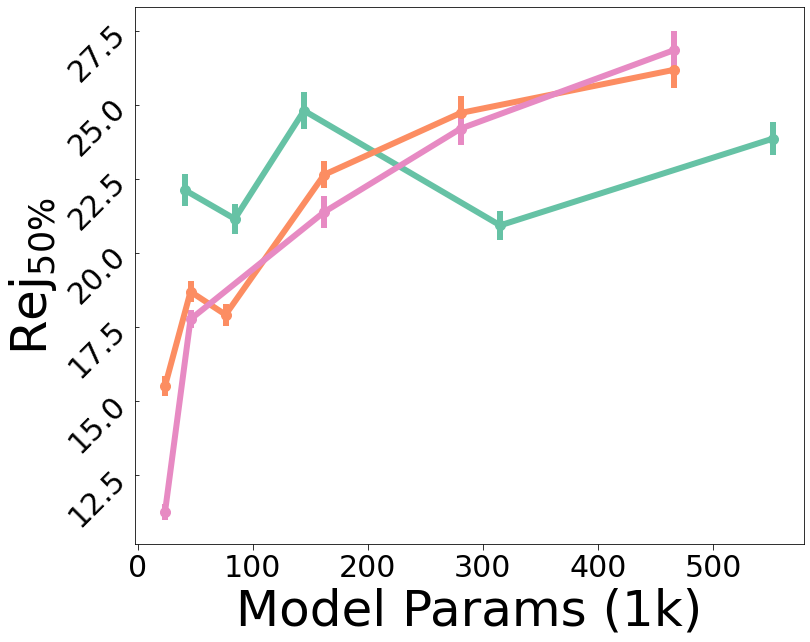

Hcc


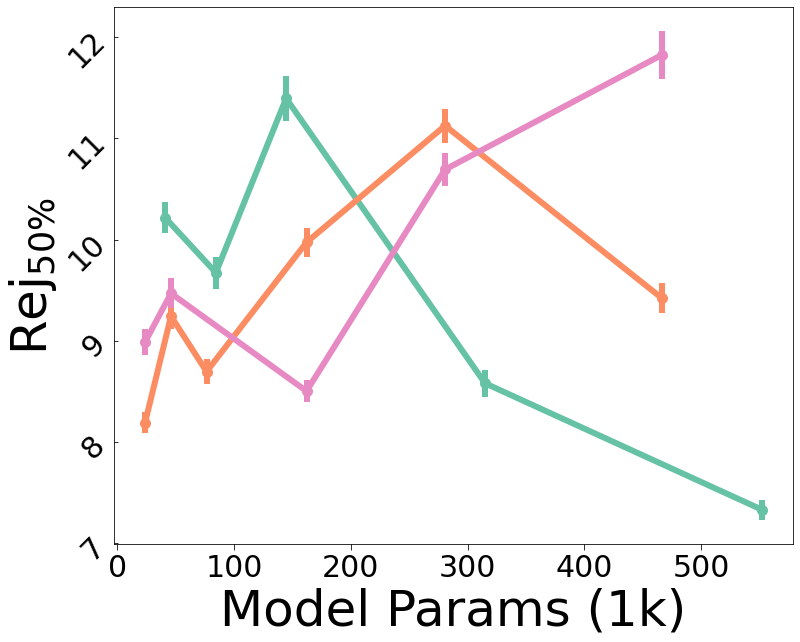

Hgg


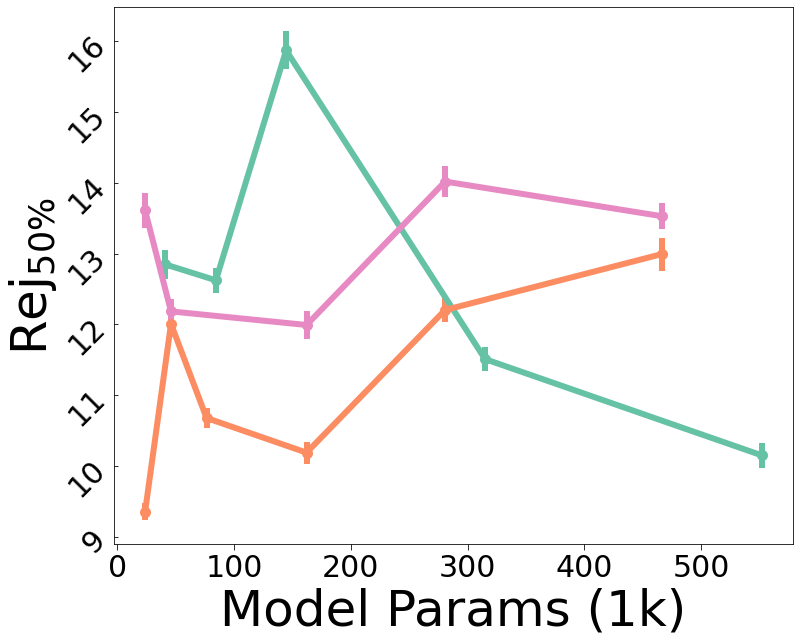

H4q


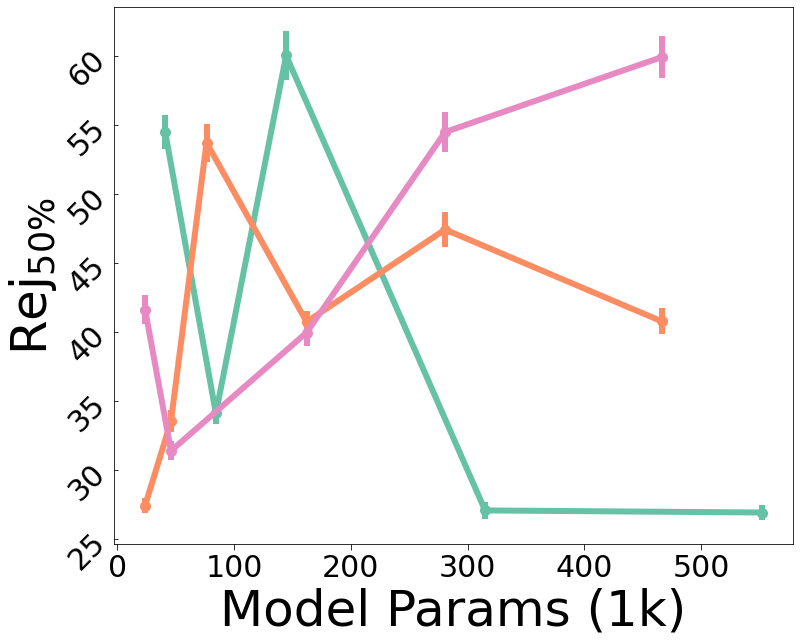

Hqql


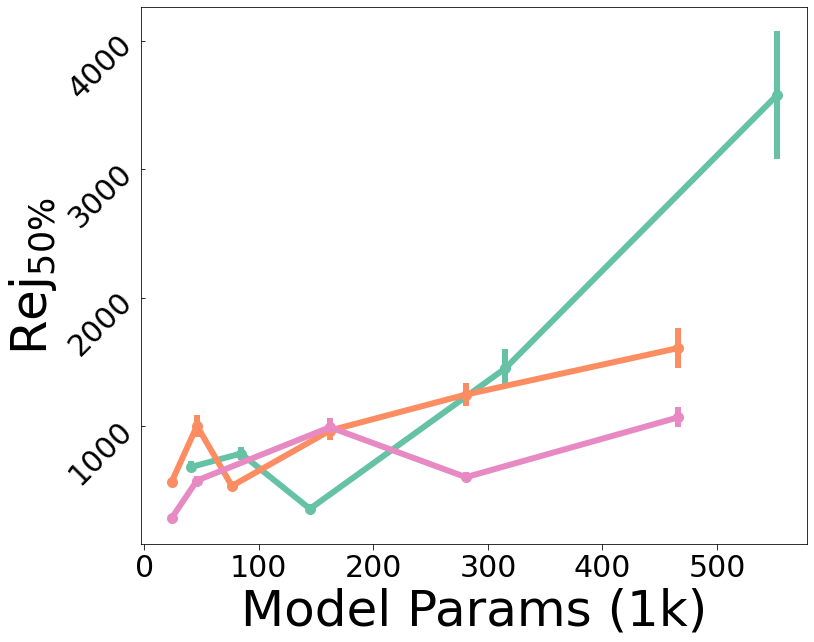

Zqq


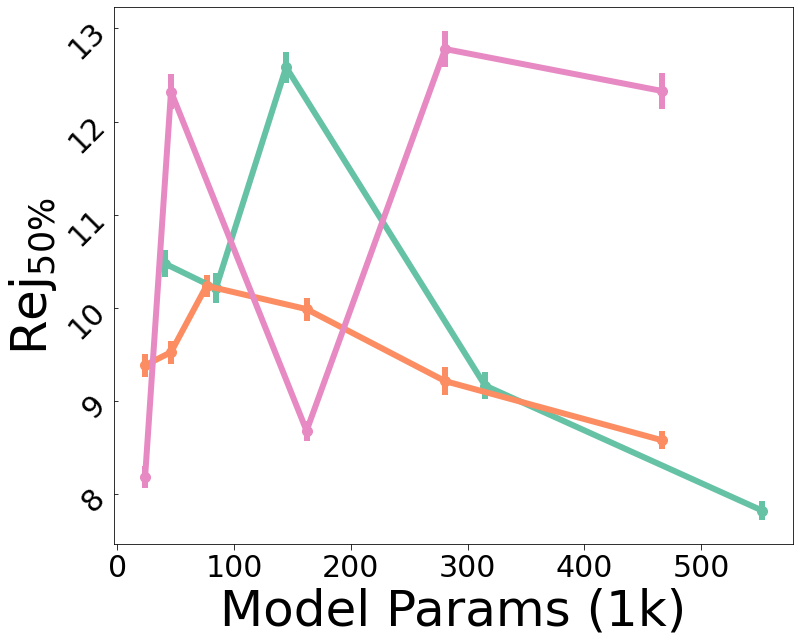

Wqq


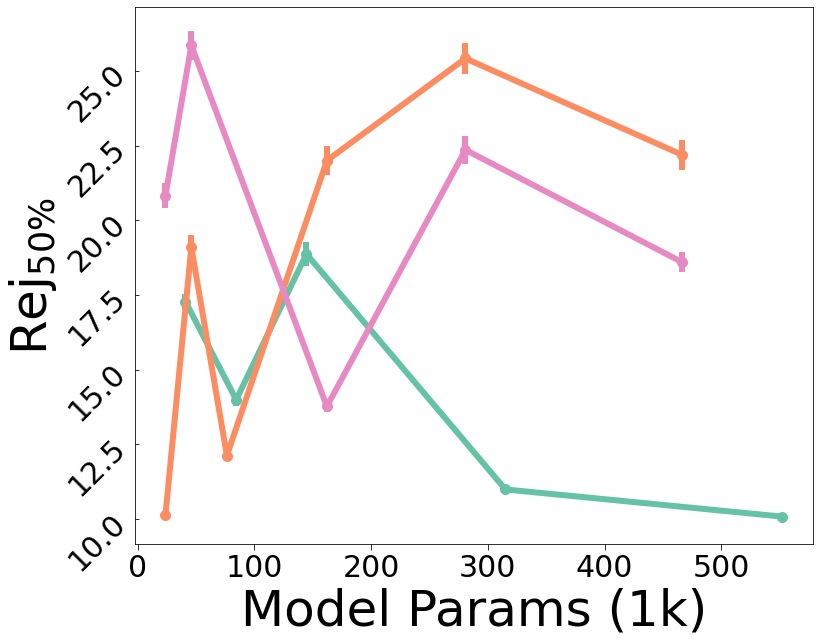

Tbqq


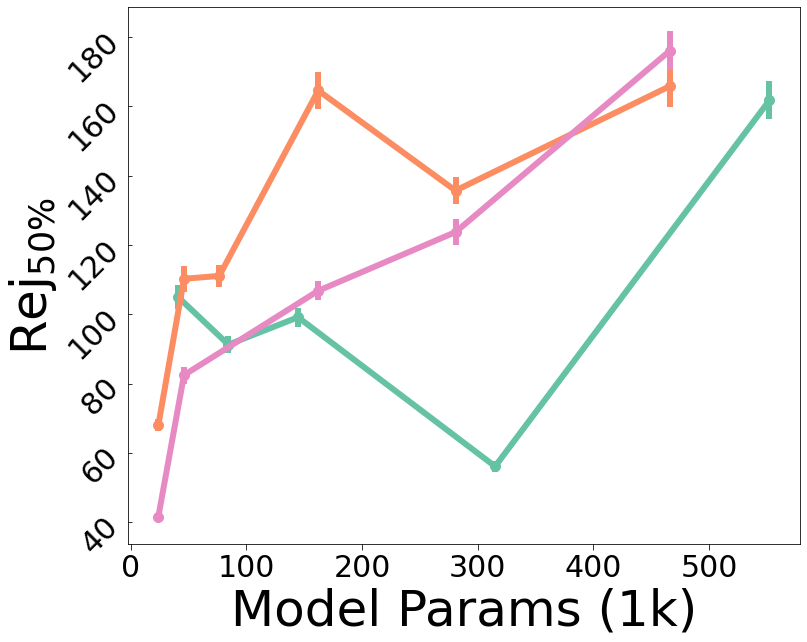

Tbl


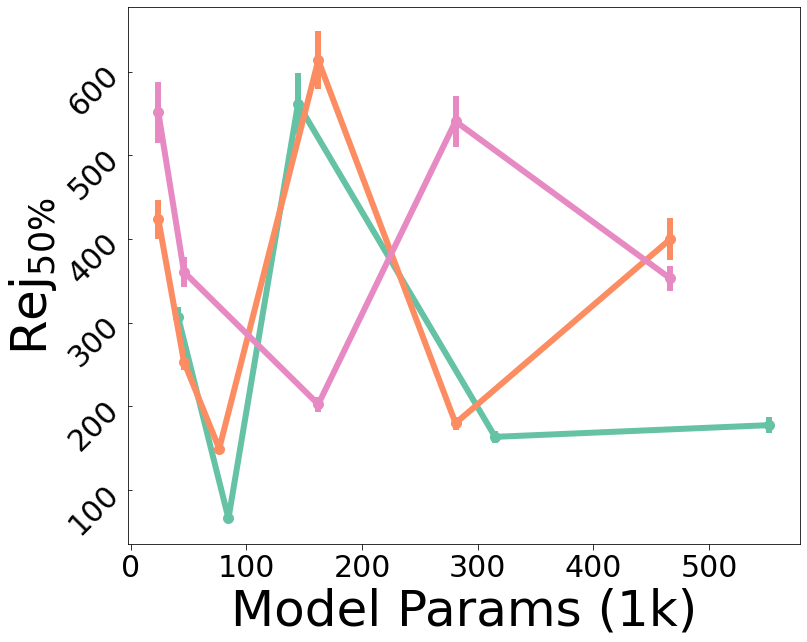

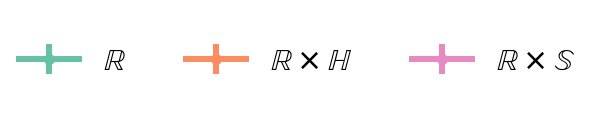

In [116]:
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}

signals = ['Hbb','Hcc','Hgg','H4q','Hqql','Zqq','Wqq', 'Tbqq', 'Tbl']
plot_rejections_model_size(results_df,
                           title = 'JetClass tagging',
                           rejection=50,
                           classes = signals, 
                           variable_to_vary='particle_dim', 
                           filter_values=filter_values,
                           filter_name = ['RxHxS','HxS'])

In [128]:
# Load the DataFrame
results_df = pd.read_csv('paper_JC_particle_lvl.csv').sort_values('overall_accuracy', ascending=False)

# Split the 'base_name' column to extract the relevant components
split_columns = results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True)


# Assigning the last four elements to new columns
results_df[['particle_geom', 'particle_dim','jet_geom','jet_dim']] = split_columns.iloc[:, 1:]


# Convert 'particle_dim' and 'jet_dim' to integers
results_df['particle_dim'] = results_df['particle_dim'].astype(int)
results_df['jet_dim'] = results_df['jet_dim'].astype(int)

results_df['particle_dim'] = results_df.apply(
    lambda row: row['particle_dim'] * 2 if len(row['particle_geom']) > 1 else row['particle_dim'],
    axis=1
)

results_df['jet_dim'] = results_df.apply(
    lambda row: row['jet_dim'] * 2 if len(row['jet_geom']) > 1 else row['jet_dim'],
    axis=1
)

# Remove the original 'base_name' column if it's no longer needed
# results_df.drop(columns=['base_name'], inplace=True)

# Create a list of tuples for the MultiIndex
index_tuples = list(results_df[['particle_geom', 'particle_dim','jet_geom', 'jet_dim']].itertuples(index=False, name=None))

# Create a MultiIndex
index = pd.MultiIndex.from_tuples(index_tuples, names=['particle_geom', 'particle_dim','jet_geom', 'jet_dim'])

# Assign the MultiIndex to the DataFrame
results_df.index = index
results_df.drop(columns=['particle_geom', 'particle_dim','jet_geom', 'jet_dim'], inplace=True)

# Define a function to average the top 2 'overall_accuracy' for each unique (particle_geom, particle_dim) combination

results_df = calculate_mean_std(results_df,top_n =5)

JetClass_particle_lvl_df = results_df




In [129]:
JetClass_particle_lvl_df

overall_accuracy_mean  \
particle_geom particle_dim jet_geom jet_dim                          
R             32           R        16                    0.700283   
              48           R        16                    0.708716   
              64           R        16                    0.713410   
              96           R        16                    0.723375   
              128          R        16                    0.724142   
              144          R        16                    0.728888   
              160          R        16                    0.725024   
RxH           32           R        16                    0.684260   
              48           R        16                    0.698104   
              64           R        16                    0.706307   
              96           R        16                    0.714443   
              128          R        16                    0.716189   
              160          R        16                    0.722802   
              200          R        16                    0.729228   
              240          R        16                    0.729153   
RxS           32           R        16                    0.670443   
              48           R        16                    0.698398   
              64           R        16                    0.701101   
              96           R        16                    0.708980   
              128          R        16                    0.715599   
              160          R        16                    0.721089   
              200          R        16                    0.724929   
              240          R        16                    0.723280   

                                             overall_accuracy_std  \
particle_geom particle_dim jet_geom jet_dim                         
R             32           R        16                   0.002426   
              48           R        16                   0.004740   
              64           R        16                   0.001990   
              96           R        16                   0.002055   
              128          R        16                   0.008554   
              144          R        16                   0.002916   
              160          R        16                   0.005127   
RxH           32           R        16                   0.001622   
              48           R        16                   0.004060   
              64           R        16                   0.005552   
              96           R        16                   0.004075   
              128          R        16                   0.001358   
              160          R        16                   0.001438   
              200          R        16                   0.002907   
              240          R        16                   0.007046   
RxS           32           R        16                   0.006717   
              48           R        16                   0.004583   
              64           R        16                   0.004697   
              96           R        16                   0.003895   
              128          R        16                   0.001888   
              160          R        16                   0.004884   
              200          R        16                   0.001907   
              240          R        16                   0.002458   

                                             overall_accuracy_min  \
particle_geom particle_dim jet_geom jet_dim                         
R             32           R        16                   0.696903   
              48           R        16                   0.705303   
              64           R        16                   0.711057   
              96           R        16                   0.721187   
              128          R        16                   0.709347   
              144          R        16                   0.724670   
              16

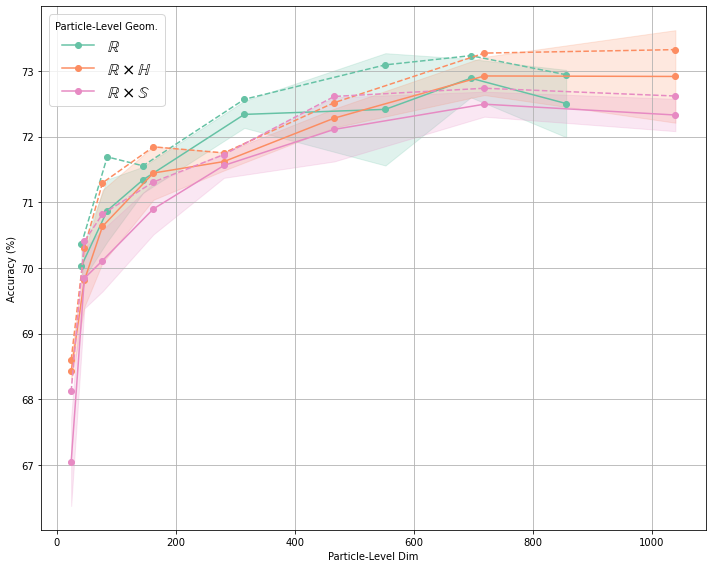

In [157]:
# Assuming 'processed_df' is your DataFrame after processing with 'calculate_mean_std'
# Define filter values
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}

# Plot the highest accuracies
plot_highest_accuracies(
    df=JetClass_jet_lvl_df,
    variable_to_vary='particle_dim',
    metric_column='overall_accuracy',
    filter_values=filter_values,
#     acc_range=(0, 100),
    title='Overall Accuracy',
    plot_trans_params = True,
    PMNN=False,
    plot_best=True,
    shaded_plot=True,
    shade_by_std=True,
    filter_names=['none'],  # Adjust as needed
    color_dict=None  # Use default colors or provide your own
)


In [161]:
# Load the DataFrame
results_df = pd.read_csv('paper_JC_jet_lvl.csv').sort_values('overall_accuracy', ascending=False)

# Split the 'base_name' column to extract the relevant components
split_columns = results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True)


# Assigning the last four elements to new columns
results_df[['particle_geom', 'particle_dim','jet_geom','jet_dim']] = split_columns.iloc[:, 1:]


# Convert 'particle_dim' and 'jet_dim' to integers
results_df['particle_dim'] = results_df['particle_dim'].astype(int)
results_df['jet_dim'] = results_df['jet_dim'].astype(int)

results_df['particle_dim'] = results_df.apply(
    lambda row: row['particle_dim'] * 2 if len(row['particle_geom']) > 1 else row['particle_dim'],
    axis=1
)

results_df['jet_dim'] = results_df.apply(
    lambda row: row['jet_dim'] * 2 if len(row['jet_geom']) > 1 else row['jet_dim'],
    axis=1
)

# Remove the original 'base_name' column if it's no longer needed
# results_df.drop(columns=['base_name'], inplace=True)

# Create a list of tuples for the MultiIndex
index_tuples = list(results_df[['particle_geom', 'particle_dim','jet_geom', 'jet_dim']].itertuples(index=False, name=None))

# Create a MultiIndex
index = pd.MultiIndex.from_tuples(index_tuples, names=['particle_geom', 'particle_dim','jet_geom', 'jet_dim'])

# Assign the MultiIndex to the DataFrame
results_df.index = index
results_df.drop(columns=['particle_geom', 'particle_dim','jet_geom', 'jet_dim'], inplace=True)

# Define a function to average the top 2 'overall_accuracy' for each unique (particle_geom, particle_dim) combination

results_df = calculate_mean_std(results_df,top_n =5)

JetClass_jet_lvl_df = results_df




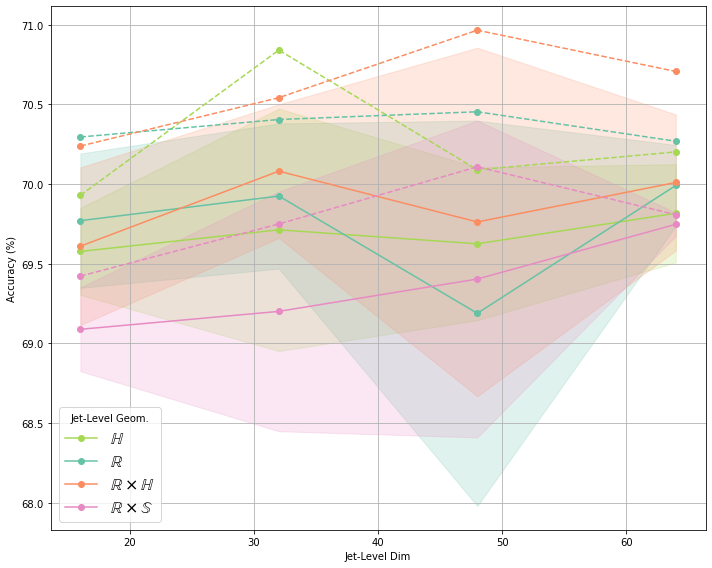

In [164]:
# Assuming 'processed_df' is your DataFrame after processing with 'calculate_mean_std'
# Define filter values
filter_values = {
    'particle_geom': 'R',
    'particle_dim': 32
}

# Plot the highest accuracies
plot_highest_accuracies(
    df=JetClass_jet_lvl_df,
    variable_to_vary='jet_dim',
    metric_column='overall_accuracy',
    filter_values=filter_values,
#     acc_range=(0, 100),
    title='Overall Accuracy',
#     plot_trans_params = True,
    PMNN=False,
    plot_best=True,
    shaded_plot=True,
    shade_by_std=True,
    filter_names=['S','HxS'],  # Adjust as needed
    color_dict=None,  # Use default colors or provide your own
)


In [ ]:
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}

signals = ['Hbb','Hcc','Hgg','H4q','Hqql','Zqq','Wqq', 'Tbqq', 'Tbl']
plot_rejections(JetClass_jet_lvl_df,
                title = 'JetClass tagging',
                rejection=50,
                classes = signals, 
                variable_to_vary='particle_dim', 
                filter_values=filter_values,
                plot_best=True, 
#                 plot_only_best=True, 
                shaded_plot=True, 
                shade_by_std=True,
                filter_names = ['S'])

In [120]:
JetClass_jet_lvl_df

overall_accuracy_mean  \
particle_geom particle_dim jet_geom jet_dim                          
R             32           H        16                    0.695774   
                                    32                    0.697132   
                                    48                    0.696253   
                                    64                    0.698170   
                           HxS      16                    0.656920   
                                    32                    0.682058   
                                    48                    0.682055   
                                    64                    0.693932   
                           R        16                    0.697705   
                                    32                    0.699252   
                                    48                    0.691891   
                                    64                    0.699916   
                           RxH      16                    0.696101   
                                    32                    0.700813   
                                    48                    0.697625   
                                    64                    0.700102   
                           RxS      16                    0.690887   
                                    32                    0.692012   
                                    48                    0.694043   
                                    64                    0.697477   
                           S        16                    0.314135   
                                    32                    0.203676   
                                    48                    0.450111   
                                    64                    0.425113   

                                             overall_accuracy_std  \
particle_geom particle_dim jet_geom jet_dim                         
R             32           H        16                   0.002728   
                                    32                   0.007607   
                                    48                   0.004797   
                                    64                   0.003083   
                           HxS      16                   0.042516   
                                    32                   0.013959   
                                    48                   0.019430   
                                    64                   0.006227   
                           R        16                   0.004215   
                                    32                   0.004555   
                                    48                   0.012095   
                                    64                   0.002542   
                           RxH      16                   0.004950   
                                    32                   0.004195   
                                    48                   0.010938   
                                    64                   0.004270   
                           RxS      16                   0.002633   
                                    32                   0.007523   
                                    48                   0.009943   
                                    64                   0.000734   
                           S        16                   0.263042   
                                    32                   0.129189   
                                    48                   0.319711   
                                    64                   0.252337   

                                             overall_accuracy_min  \
particle_geom particle_dim jet_geom jet_dim                         
R             32           H        16                   0.692469   
                                    32                   0.689489   
                                    48                   0.688935   
                                    64                   0.693848   
               

Plotting for class: Hbb


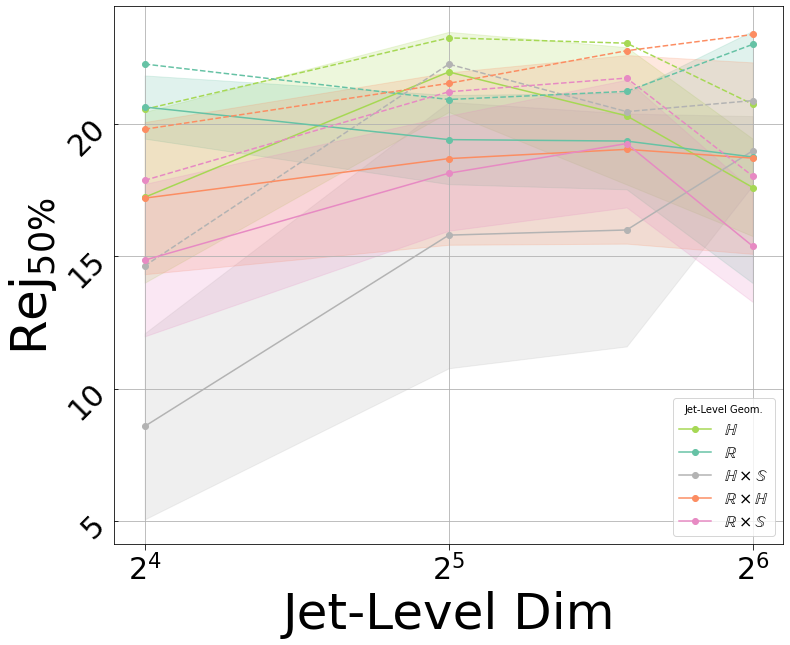

Plotting for class: Hcc


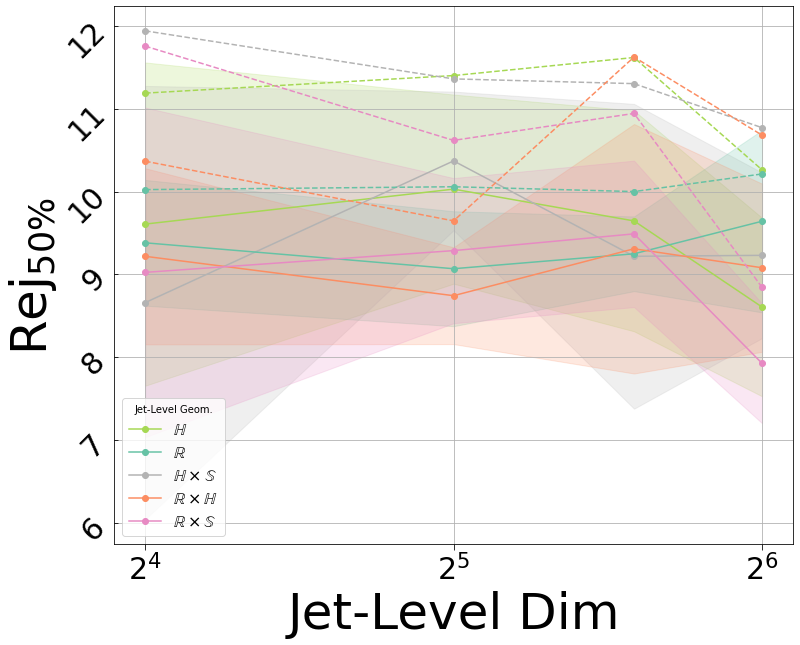

Plotting for class: Hgg


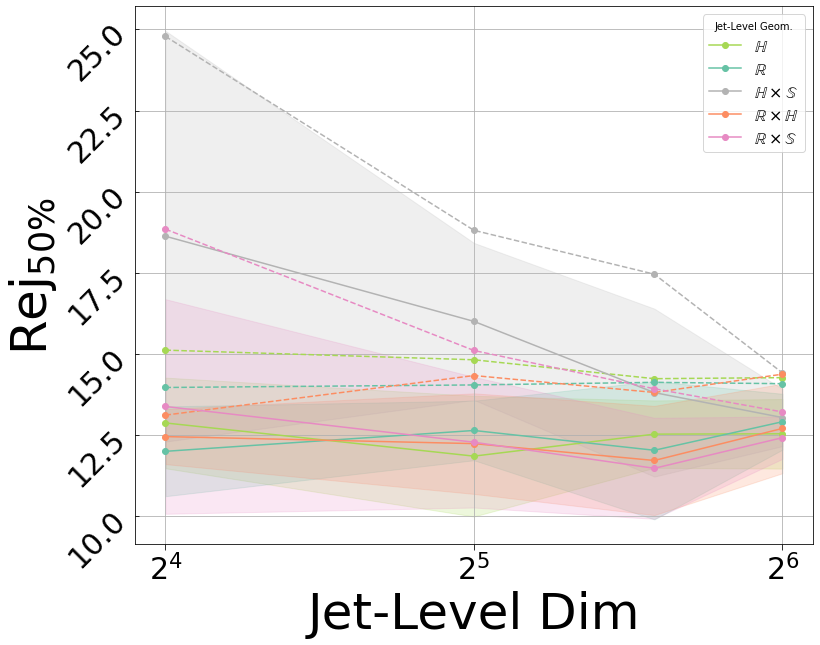

Plotting for class: H4q


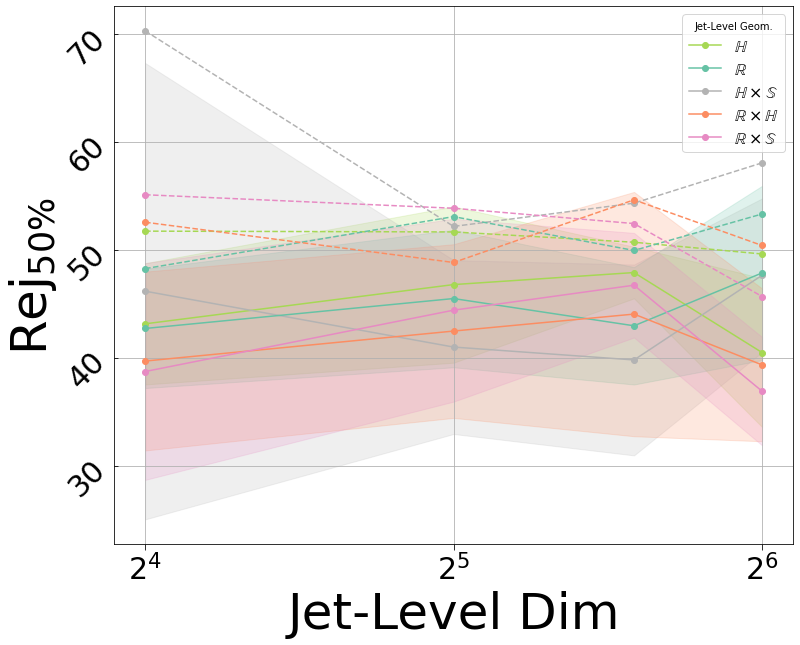

Plotting for class: Hqql


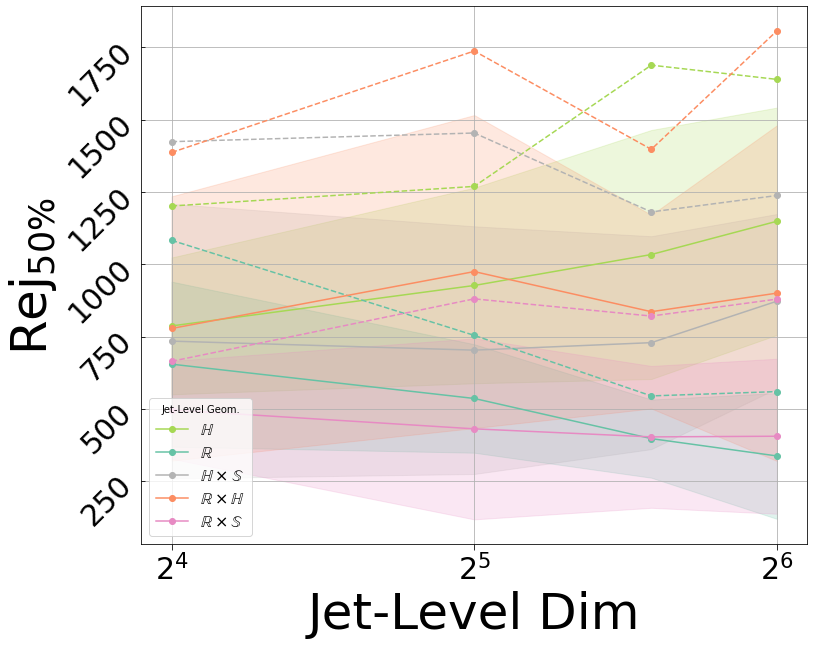

Plotting for class: Zqq


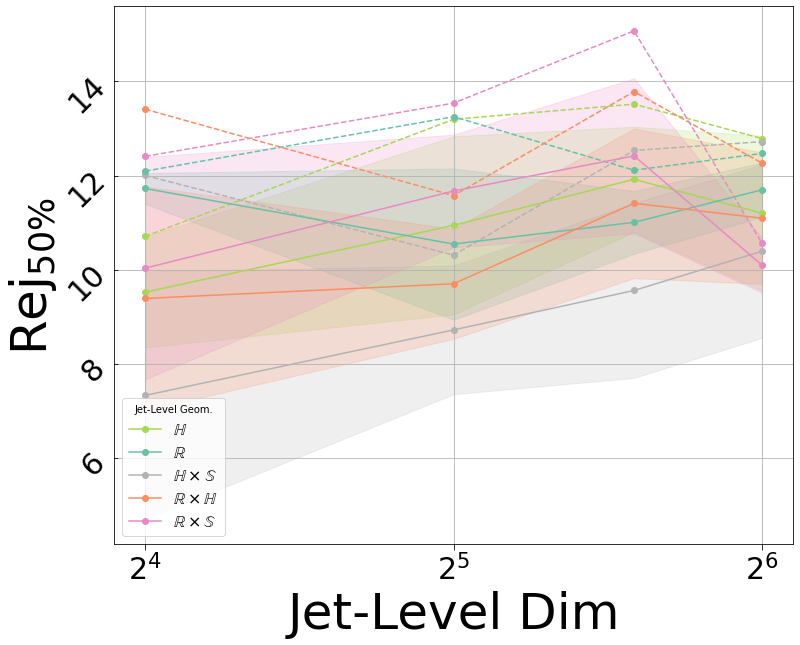

Plotting for class: Wqq


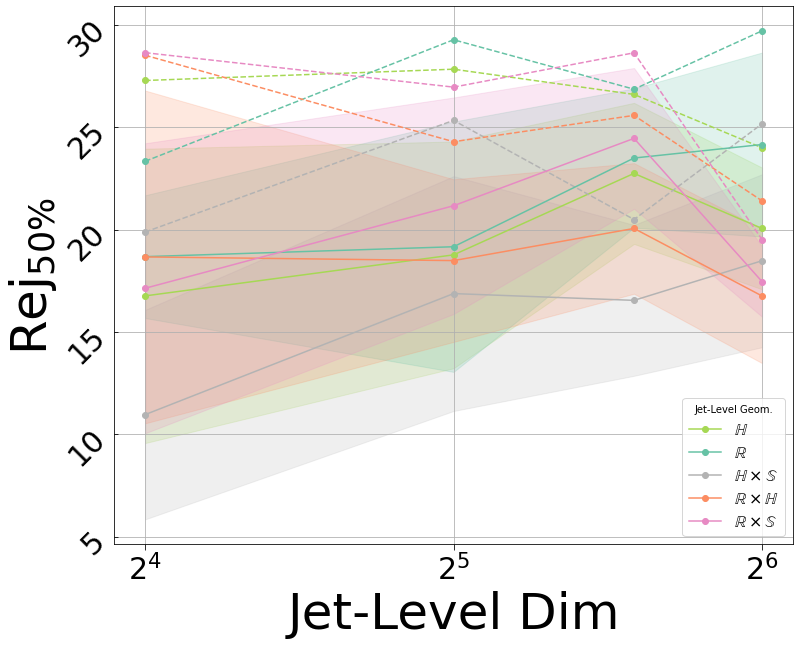

Plotting for class: Tbqq


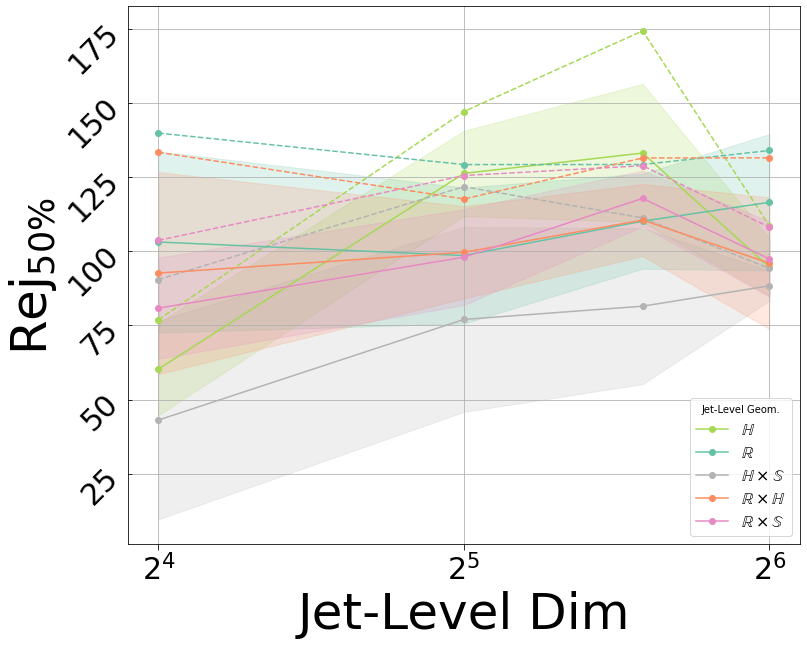

Plotting for class: Tbl


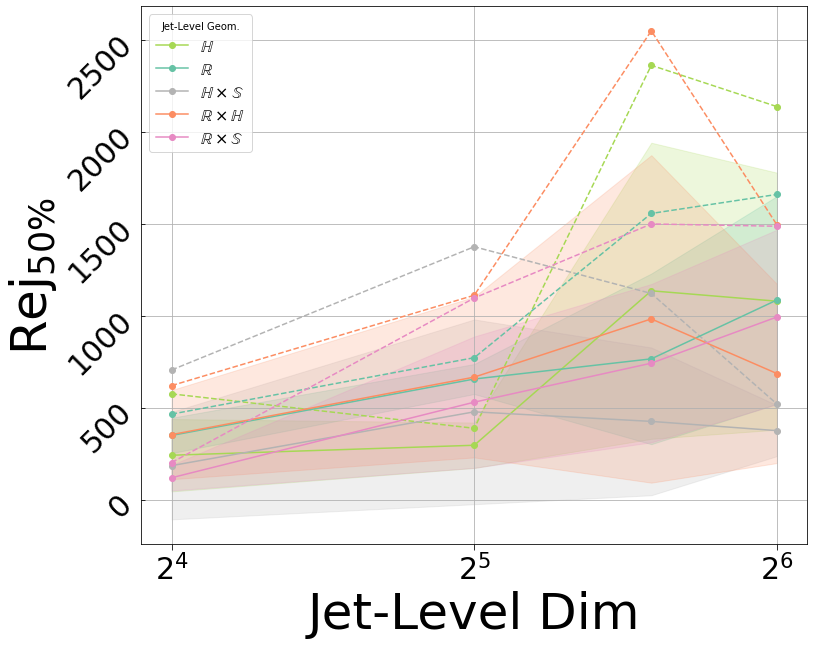

In [125]:
filter_values = {
    'particle_geom': 'R',
    'particle_dim': 32
}

signals = ['Hbb','Hcc','Hgg','H4q','Hqql','Zqq','Wqq', 'Tbqq', 'Tbl']
plot_rejections(JetClass_jet_lvl_df,
                title = 'JetClass tagging',
                rejection=0,
                classes = signals, 
                variable_to_vary='jet_dim', 
                filter_values=filter_values,
                plot_best=True, 
#                 plot_only_best=True, 
                shaded_plot=True, 
                shade_by_std=True,
                filter_names = ['S'])